# ทดสอบรวมฝนรายชั่วโมงเป็นฝนรายวัน ใช้คอลัมน์ full_date และ code พลอต density ใช้ ZR MP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## read cleansing 

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df
#df.head()

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### คำนวน rain estimates จาก ZRs

In [4]:
### ZR marshall/palmer
a=200. 
b=1.6
df['rr_MP_c1']=((10**(df['dBZ_c1']/10.))/a)**(1/b)
df['rr_MP_c2']=((10**(df['dBZ_c2']/10.))/a)**(1/b)
df['rr_MP_c3']=((10**(df['dBZ_c3']/10.))/a)**(1/b)
df['rr_MP_c4']=((10**(df['dBZ_c4']/10.))/a)**(1/b)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0,2.200646,2.105109,1.903371,1.567682
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8,0.503733,0.483794,0.484834,0.507355
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0,1.846862,1.908376,2.050093,2.258788
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820251,1.820251
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0,2.440965,2.414866,1.300128,0.925629
...,...,...,...,...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0,35.399949,35.480399,35.561149,35.642533
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0,0.849184,0.849184,0.849184,0.849184
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0,2.269228,2.271807,2.274313,2.368019
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0,0.172182,0.171911,0.171639,0.172934


In [5]:
## ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,2018-06-01-00:00,CMSG,0.0,2.200646,2.105109,1.903371,1.567682
1,2018-06-01-00:00,CTKN,10.8,0.503733,0.483794,0.484834,0.507355
2,2018-06-01-00:00,KGTP,0.0,1.846862,1.908376,2.050093,2.258788
3,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820251,1.820251
4,2018-06-01-00:00,NAN008,0.0,2.440965,2.414866,1.300128,0.925629
...,...,...,...,...,...,...,...
15877,2018-09-21-23:00,PPTC,0.0,35.399949,35.480399,35.561149,35.642533
15878,2018-09-21-23:00,TBR013,0.0,0.849184,0.849184,0.849184,0.849184
15879,2018-09-21-23:00,TBW014,0.0,2.269228,2.271807,2.274313,2.368019
15880,2018-09-21-23:00,WTBT,0.0,0.172182,0.171911,0.171639,0.172934


### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพือ่ใช้ร่วมกับคอลัมน์ code

In [6]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

# The resulting DataFrame 'aggregated_data' will have the aggregated values
print(aggregated_data)

       date_only    code  rain_truth   rr_MP_c1   rr_MP_c2   rr_MP_c3  \
0     2018-06-01    BPPS         0.2   2.224783   2.364574   2.692157   
1     2018-06-01    BRKM         0.0   1.505886   1.525648   1.444603   
2     2018-06-01    BWKG         0.0   3.995276   4.059923   4.273930   
3     2018-06-01    CMSG         4.8  23.705733  23.180283  22.594044   
4     2018-06-01    CNDN         0.0  19.720062  19.699903  17.066963   
...          ...     ...         ...        ...        ...        ...   
2538  2018-09-21    WTBT         0.0   0.773975   0.773706   0.773441   
2539  2018-09-21    WTLG         0.0   4.336520   4.343484   4.452204   
2540  2018-09-21  YOM007         0.0   0.620694   0.599843   0.577298   
2541  2018-09-21  YOM008         0.0   0.383418   0.354150   0.366337   
2542  2018-09-21  YOM009         0.0  64.679173  64.620891  64.727207   

       rr_MP_c4  
0      2.978155  
1      1.434436  
2      3.657418  
3     20.573030  
4      4.122306  
...         ...

In [7]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_MP_c1']>0]

In [8]:
df_.reset_index(drop=True, inplace=True)

In [9]:
df_.describe()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
count,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,6.041728,24.893924,24.462577,23.834845,22.629126
std,9.312912,26.671079,25.373615,24.200754,22.947070
min,0.200000,0.254467,0.254467,0.248829,0.204654
25%,0.600000,7.911515,8.176571,8.104146,7.609847
50%,2.000000,15.830127,16.213940,16.376425,15.270341
75%,7.400000,32.379022,32.037420,31.249555,29.758160
max,77.800000,228.183390,227.045673,228.916910,230.459121


In [10]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
rain_truth,1.000000,0.540352,0.554213,0.552960,0.548257
rr_MP_c1,0.540352,1.000000,0.961138,0.928622,0.871465
rr_MP_c2,0.554213,0.961138,1.000000,0.970916,0.914097
rr_MP_c3,0.552960,0.928622,0.970916,1.000000,0.937978
rr_MP_c4,0.548257,0.871465,0.914097,0.937978,1.000000


## พลอต scatter คำนวณสถิติ และ พลอตค่า metrics

In [11]:
def density_plot(rain_truth, rain_radar):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')
    plt.legend()

    # Display the plot
    plt.show()


RMSE: 29.7425491597901
MSE: 884.6192305225309
MAE: 19.459217121427617
R-squared: -0.24459852895950673
Correlation coefficient (r): 0.5403522249181237
P-value: 5.983273678013612e-94


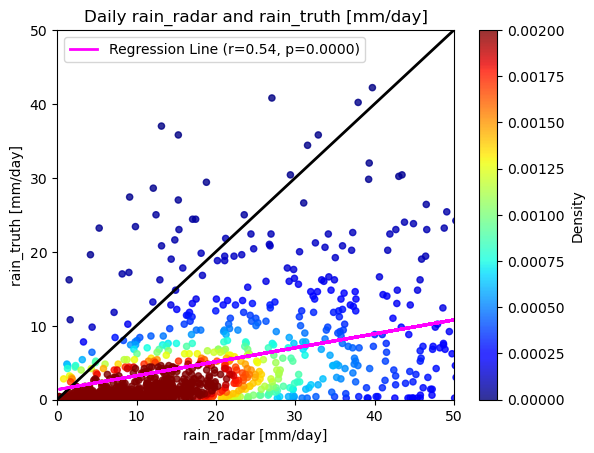

In [12]:
density_plot(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 28.417829835286987
MSE: 807.5730525473273
MAE: 18.89351725697328
R-squared: -0.2553685186307597
Correlation coefficient (r): 0.5542126186083381
P-value: 1.0097427302561151e-99


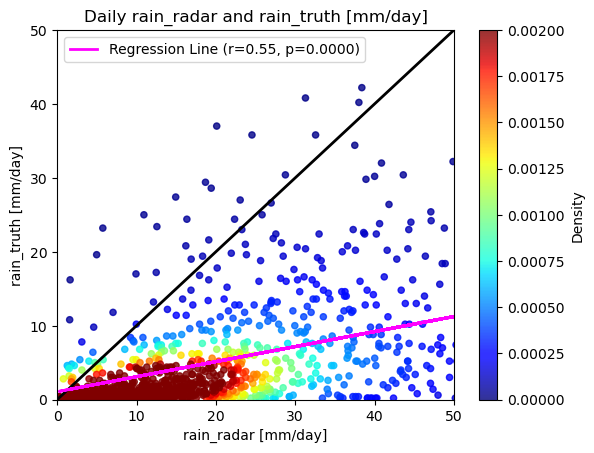

In [13]:
density_plot(df_['rain_truth'],df_['rr_MP_c2'])

RMSE: 27.19201125082334
MSE: 739.4054758649032
MAE: 18.196440807745823
R-squared: -0.26351077622868546
Correlation coefficient (r): 0.552959607411898
P-value: 3.445735945471753e-99


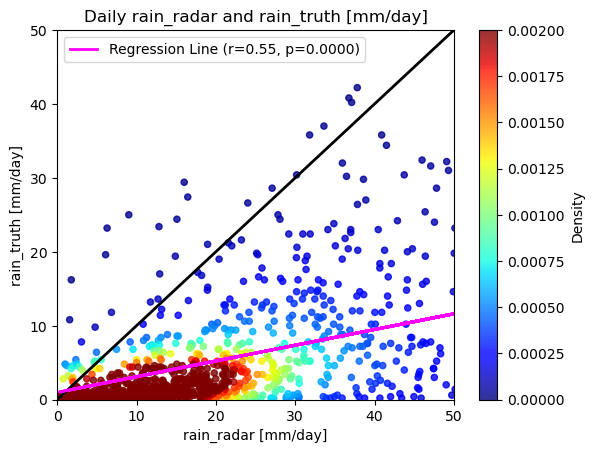

In [14]:
density_plot(df_['rain_truth'],df_['rr_MP_c3'])

RMSE: 25.569546195781275
MSE: 653.8016926581927
MAE: 17.060411696901284
R-squared: -0.24264087846067595
Correlation coefficient (r): 0.5482572853836608
P-value: 3.2940608726424564e-97


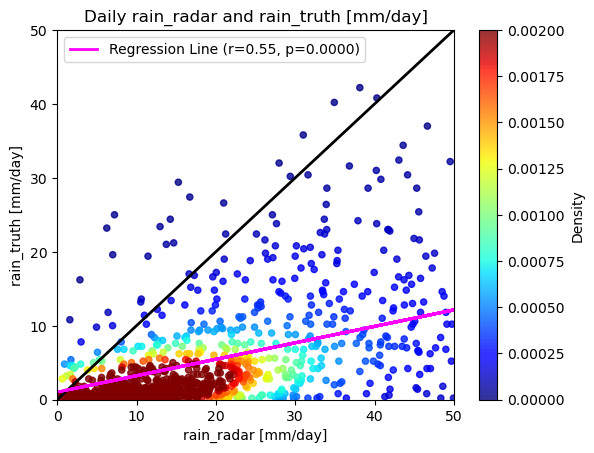

In [15]:
density_plot(df_['rain_truth'],df_['rr_MP_c4'])

### คำนวณสถิติ และ พลอตค่า metrics

In [16]:
def density_plot_joint(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')
    
    max_=50

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


RMSE: 29.742549159790105
MSE: 884.6192305225311
MAE: 19.459217121427617
R-squared: -0.24459852895950718
Correlation coefficient (r): 0.5403522249181232
P-value: 5.98327367801668e-94


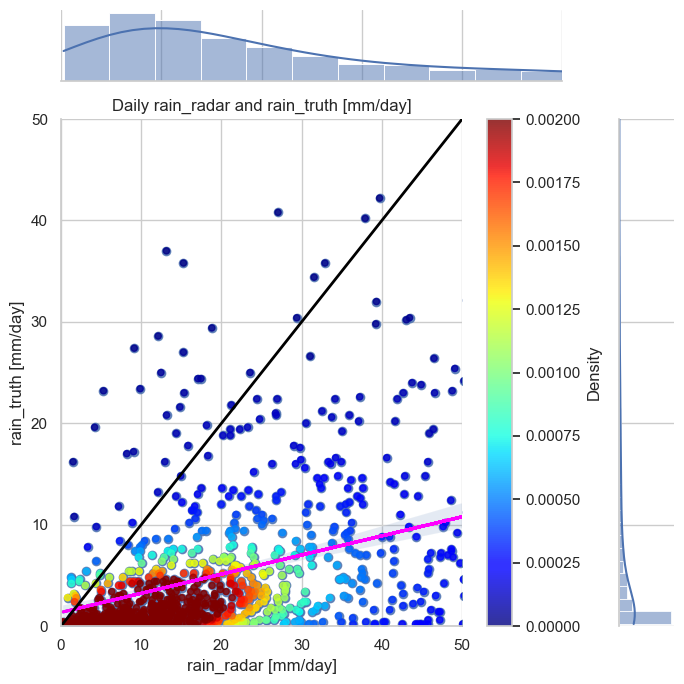

In [17]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 28.417829835286987
MSE: 807.5730525473273
MAE: 18.893517256973276
R-squared: -0.2553685186307597
Correlation coefficient (r): 0.5542126186083378
P-value: 1.0097427302564887e-99


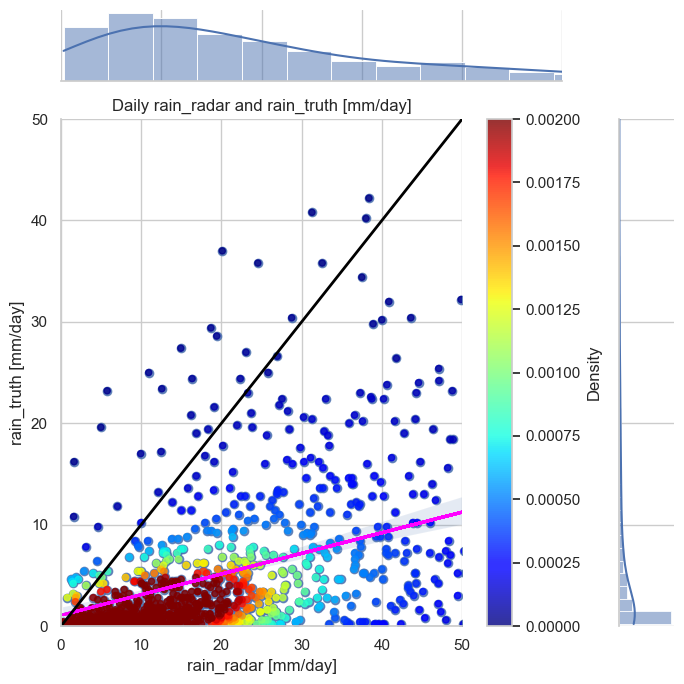

In [18]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c2'])

RMSE: 27.19201125082334
MSE: 739.4054758649032
MAE: 18.196440807745827
R-squared: -0.2635107762286857
Correlation coefficient (r): 0.5529596074118981
P-value: 3.4457359454710663e-99


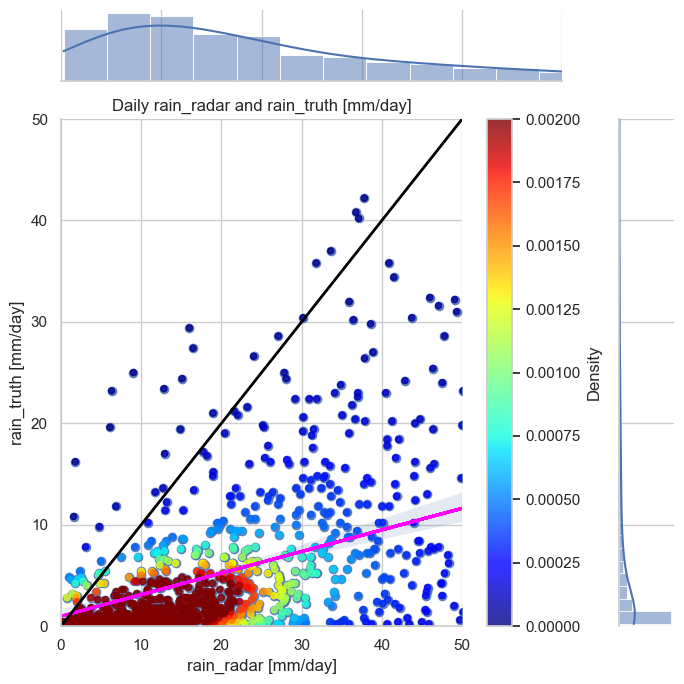

In [19]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c3'])

RMSE: 25.569546195781275
MSE: 653.8016926581926
MAE: 17.060411696901284
R-squared: -0.24264087846067572
Correlation coefficient (r): 0.5482572853836609
P-value: 3.294060872642081e-97


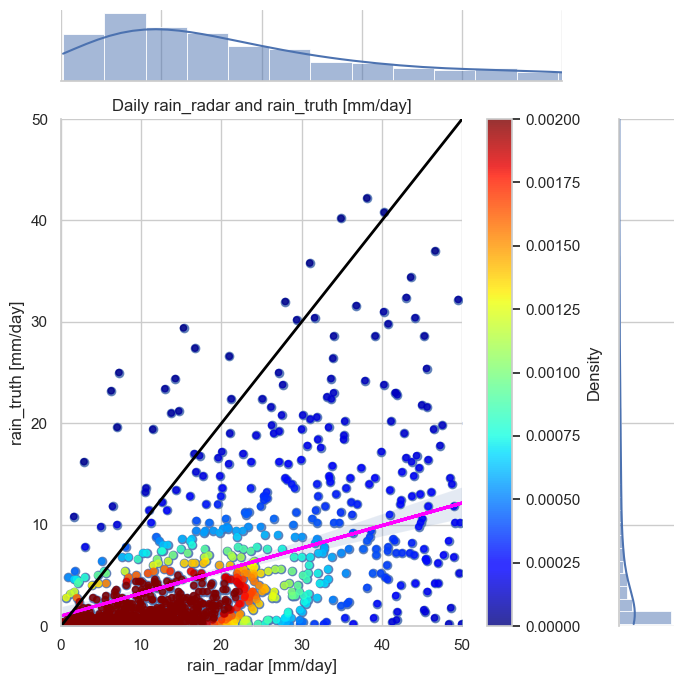

In [20]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c4'])

## รวมฝนรายวันเป็นฝนทั้งเหตุการณ์ของแต่ละสถานี

In [21]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
df_

,date_only,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,2018-06-01,BPPS,0.2,2.224783,2.364574,2.692157,2.978155
1,2018-06-01,CMSG,4.8,23.705733,23.180283,22.594044,20.573030
2,2018-06-01,CTKN,10.8,1.641343,1.575050,1.574212,1.596140
3,2018-06-01,KGKG,0.4,10.394456,11.232946,11.897432,10.804837
4,2018-06-01,KGLN,0.2,27.744992,27.461413,25.036415,6.859479
...,...,...,...,...,...,...,...
1222,2018-09-20,WTLG,0.2,5.711296,5.560490,5.394695,2.275605
1223,2018-09-21,CNDN,0.2,2.699788,2.991048,2.757272,2.436189
1224,2018-09-21,NAN013,24.8,92.613751,92.937103,93.794543,97.951201
1225,2018-09-21,PIN003,2.4,27.102171,25.873414,22.230179,16.332518


In [23]:
import pandas as pd

# Assuming df_ is your DataFrame
# Group by 'code' and calculate the mean for each group
aggregated_df = df_.groupby('code').mean().reset_index()

# Display the aggregated DataFrame
print("Aggregated DataFrame:")
df_=aggregated_df
print(df_)


Aggregated DataFrame:
      code  rain_truth   rr_MP_c1   rr_MP_c2   rr_MP_c3   rr_MP_c4
0     BDLH    5.726316  18.525705  16.768798  15.697606  15.416191
1     BMNK    0.200000   4.654848   4.943470   5.292926   5.503839
2     BPPS    5.341176  23.430848  21.163535  17.891115  15.625591
3     BRKM    3.333333  17.241049  17.212996  17.114880  15.550076
4     BWKG    5.162500  14.495178  14.405885  14.458121  14.347102
..     ...         ...        ...        ...        ...        ...
81  YOM006    4.892308  18.790566  18.179006  17.544410  16.528351
82  YOM007    3.800000  16.613092  18.655920  23.240556  38.140917
83  YOM008    4.781818  14.782286  14.867209  14.929179  15.678745
84  YOM009    7.600000  28.413238  33.672012  32.845197  30.956902
85  YOM012    0.342857  22.226794  22.623432  22.334217  21.485989

[86 rows x 6 columns]


In [24]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
rain_truth,1.000000,0.502233,0.521288,0.520565,0.500779
rr_MP_c1,0.502233,1.000000,0.987285,0.957053,0.900271
rr_MP_c2,0.521288,0.987285,1.000000,0.987240,0.938892
rr_MP_c3,0.520565,0.957053,0.987240,1.000000,0.971306
rr_MP_c4,0.500779,0.900271,0.938892,0.971306,1.000000


RMSE: 23.221747559815256
MSE: 539.2495597317858
MAE: 19.43880955907687
R-squared: -1.769156585167631
Correlation coefficient (r): 0.5022334851851393
P-value: 8.351625589701345e-07


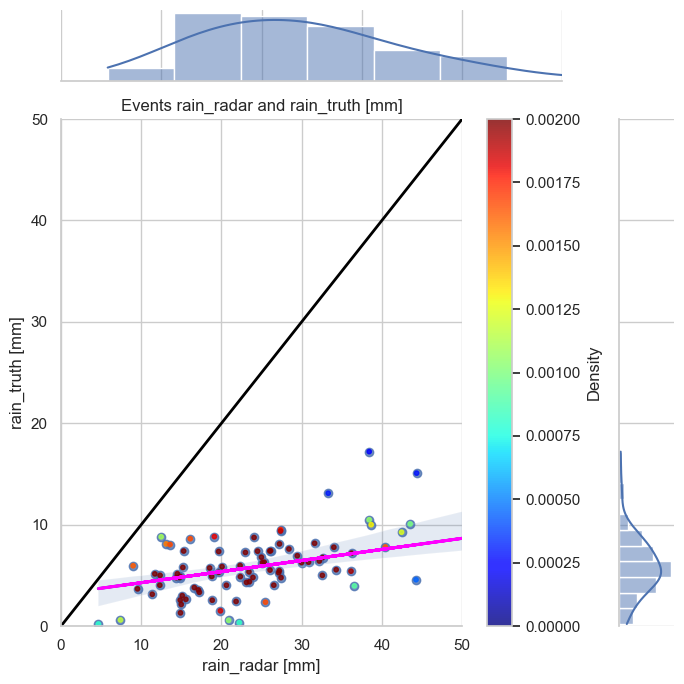

In [25]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 22.72985591630627
MSE: 516.6463499760431
MAE: 19.133280699794582
R-squared: -1.802756010596417
Correlation coefficient (r): 0.5212879211007617
P-value: 2.659504814343839e-07


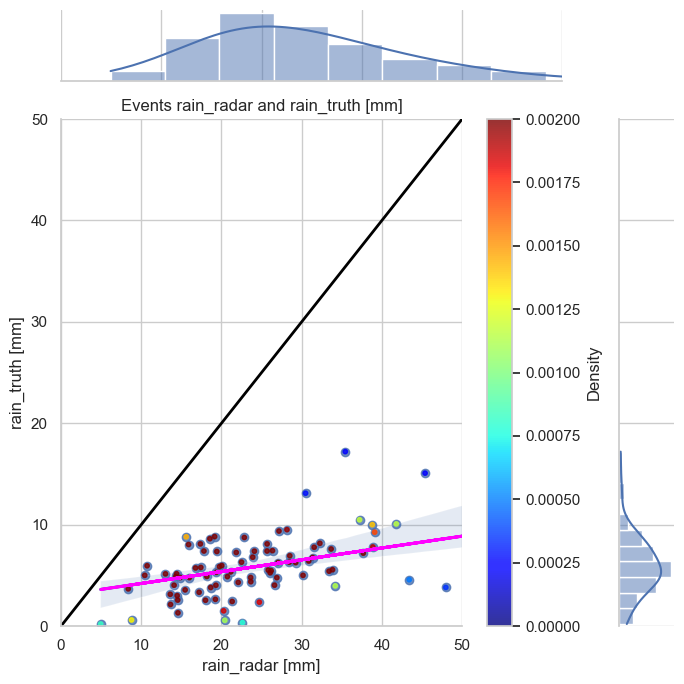

In [26]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c2'])

RMSE: 22.226850095225554
MSE: 494.0328651556282
MAE: 18.593852552438843
R-squared: -1.7188623146928692
Correlation coefficient (r): 0.5205650007259832
P-value: 2.7810771298642816e-07


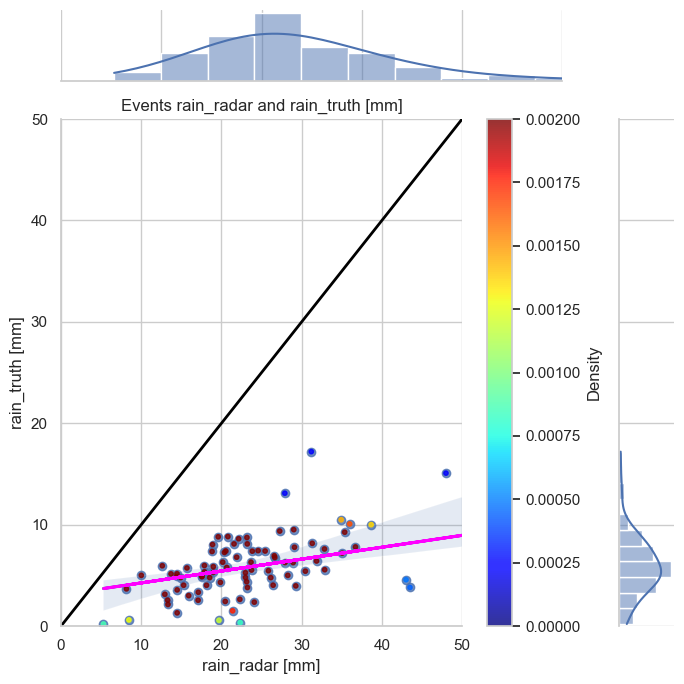

In [27]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c3'])

RMSE: 20.826109457853214
MSE: 433.72683515048305
MAE: 17.450749931612954
R-squared: -1.7408968994131464
Correlation coefficient (r): 0.5007788595580921
P-value: 9.088358676486145e-07


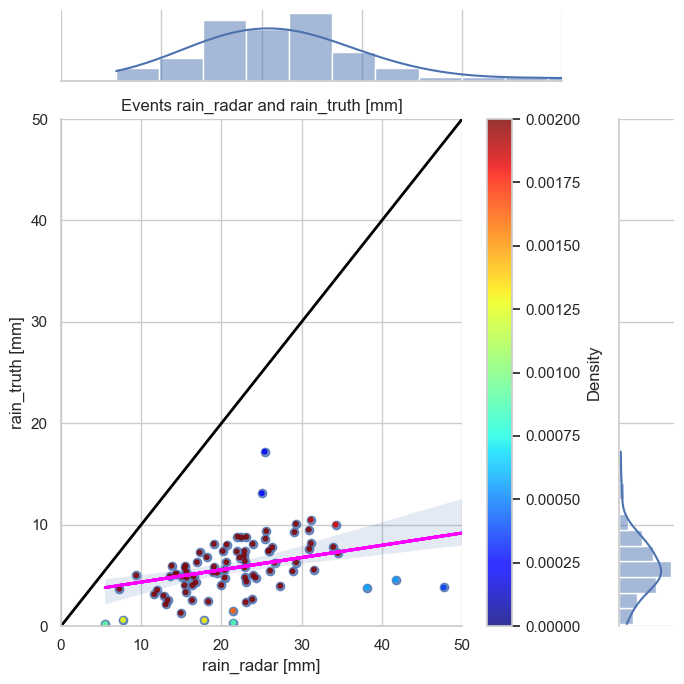

In [28]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c4'])

## หา bias และปรับแก้แบบ MFB Mean Field Bias Correction